In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
##Code adapated from online tutorials for ML in python

# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.metrics import RocCurveDisplay


# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# Bulk RNA data

In [103]:
bulk_RNA = pd.read_csv('/Users/alex/Documents/BIOL0041-Project/OAC_masters_project/data/bulk_RNA_classified.csv', header=None)

/var/folders/gv/57z5thfs7kqfq2njhk1gg9jc0000gn/T/ipykernel_26321/3865713961.py:1: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,2

In [104]:
bulk_RNA.columns = bulk_RNA.loc[0]

In [105]:
bulk_RNA = bulk_RNA.drop(0)

In [106]:
bulk_RNA = bulk_RNA.iloc[:, 2:]

In [107]:
bulk_RNA = bulk_RNA.dropna()

In [108]:
bulk_RNA

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A2ML1-AS2,A2MP1,A3GALT2,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11AP1,ZYG11B,ZYX,ZZEF1,proliferation
1,0.0087336536379343,0.0133457046232529,0.80604351550675,7.5208941894126,0.145059715401391,0.106160262737233,0,0,0.0218858774646834,0.0634808010105594,...,1.22199019355772,0.879612312072645,1.09462491859372,1.39129005283473,0.0487439942097609,0,1.93153498688702,1.7565262510112,2.85911806329913,slow
2,0.0192261510465025,0.0347975384215614,0.36039227503818,4.30690209645632,0.111202558769224,51.4333480144021,0.44528531466883,0.17380739398127,0.00150560264983775,0.0356670143948806,...,2.31740260990306,1.2311802391106,1.74328384573374,2.1209741952285,0.128058129560547,0,3.20822537075976,2.76859278857937,2.56459117746313,slow
3,0,0.0242221090391965,0.825252803997326,11.1758336451964,0.220653408482655,6.86163392003617,0,0.468817037906314,0.0541482275977969,0,...,4.44185916034676,0.672295403833369,2.04351454042101,4.02305783980541,0.0115138624821427,0,4.48345918518779,11.117836860983,3.74177147592089,fast
4,0.0275925885896029,0.0257754886583909,0.0797000796441355,29.9213366686229,0.352206082792572,80.820656277951,0.243449653308266,0,0.0444503226956027,0.0292501975798342,...,1.73811283676164,1.66517878737658,2.97640734347975,1.53459158000059,0.0735135238659434,0,6.40496731503743,6.1764311526277,3.09531230187777,slow
5,0.00925153743778099,0.0374498834211197,1.26611129132244,20.9692113627648,0.246023776018418,0.274345346362618,0,0,0.00386394253610255,0,...,4.60687942656297,2.24154701766745,3.51195231145865,4.71580715033548,0.0205403320539141,0,4.76407434910555,6.95441242908738,3.71727761268704,fast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,0.060011,0.24462,0.134819,71.696401,0.400414,183.8762,0.084235,0,0.041013,0.010121,...,2.758716,1.693728,2.454762,2.359721,0.218023,0,4.860702,7.490299,3.101638,slow
195,0.023068,0.147253,0.051825,17.486941,0.392609,41.832696,0.059364,0,0.067442,0.014265,...,1.888374,1.675736,2.013144,1.965655,0.619722,0,4.543191,4.978495,3.833931,slow
197,0.0,0.024048,0.351819,20.684461,0.054766,0.983334,0.0,0,0.0,0.031837,...,1.057016,0.483326,0.913484,1.689984,0.308634,0,3.485757,4.211851,3.057637,slow
198,0.0,0.024048,0.351819,20.684461,0.054766,0.983334,0.0,0,0.0,0.031837,...,1.057016,0.483326,0.913484,1.689984,0.308634,0,3.485757,4.211851,3.057637,slow


## Data pre-processing

In [109]:
bulk_RNA['proliferation'] = bulk_RNA['proliferation'].map({'slow':1,'fast':0})


In [110]:
bulk_RNA['proliferation'].value_counts()

proliferation
1    113
0     81
Name: count, dtype: int64

In [111]:
# Split the data into features (X) and target (y)
X = bulk_RNA.drop('proliferation', axis=1)
y = bulk_RNA['proliferation']

In [112]:
X = pd.DataFrame(X)
X = X.apply(pd.to_numeric, errors='coerce')


## Removing genes not expressed in at least 45% of dataset

In [113]:
81/(81+113)

0.4175257731958763

In [114]:
X.shape

(194, 52031)

In [115]:
zero_prop = (X == 0).sum()/len(X)

In [116]:
zero_prop.sort_values(ascending=False).head(20)

0
MTND4LP25      1.0
AC008758.5     1.0
USP9YP29       1.0
IGLV3-30       1.0
RNU6-146P      1.0
AL157387.2     1.0
AC008763.3     1.0
AC096586.1     1.0
AC096582.2     1.0
OR4K6P         1.0
RNU6-152P      1.0
AC096570.2     1.0
USP9YP26       1.0
USP9YP25       1.0
AC096570.1     1.0
USP9YP24       1.0
COMMD3-BMI1    1.0
RNU6-153P      1.0
AC073352.2     1.0
TRIM60P16      1.0
dtype: float64

In [117]:
X = X.loc[:, zero_prop <= 0.45]

## 1000 most variably expressed genes

In [118]:
var_X = X.var(numeric_only=True)
top_1000_VG = var_X.sort_values(ascending=False).head(1000).index
X = X[top_1000_VG]

In [119]:
X.shape

(194, 1000)

## Split data into test/train

In [120]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

## RF w/ training-testing-predicting

In [21]:
param_dist = {'bootstrap': [True, False],
              'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10],
              'n_estimators': [100, 150, 200, 250, 500, 750, 1000] 
              }

# Create a random forest classifier
rf = RandomForestClassifier(criterion='gini', random_state= 42)

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=2000, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

/Users/alex/miniconda3/envs/ML_env/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
5010 fits failed out of a total of 10000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5010 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/alex/miniconda3/envs/ML_env/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/alex/miniconda3/envs/ML_env/lib/python3.13/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/Users/alex/miniconda3/en

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=2000,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 150, 200, 250,
                                                         500, 750, 1000]})

In [22]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}


In [23]:
#best_rf = RandomForestClassifier(criterion='gini', random_state= 42, n_estimators = 500, min_samples_split = 2, min_samples_leaf = 1, max_features = 'sqrt', max_depth = 10, bootstrap = True)

In [24]:
#best_rf = RandomForestClassifier(criterion='gini', random_state= 42, n_estimators = 250, min_samples_split = 5, min_samples_leaf = 4, max_features = 'sqrt', max_depth = None, bootstrap = True)

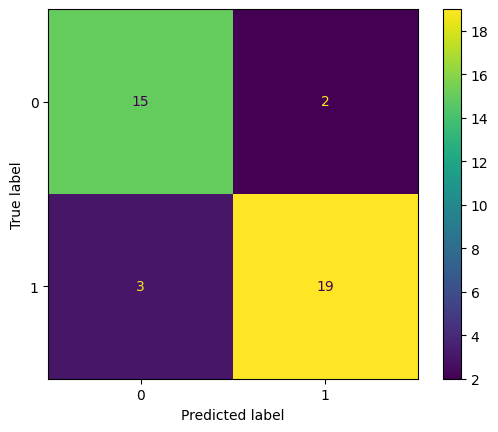

In [25]:
best_rf.fit(X_train, y_train)

# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [26]:
y_pred = best_rf.predict(X_test)

probs_rf = best_rf.predict_proba(X_test) [:,1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8717948717948718
Precision: 0.9047619047619048
Recall: 0.8636363636363636


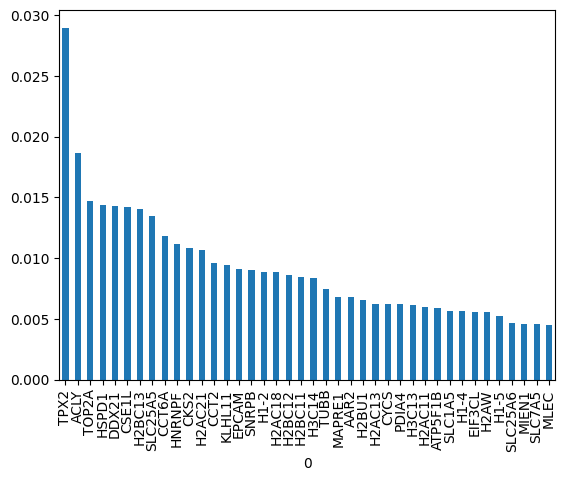

In [ ]:
# Order genes by importance
RF_feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

RF_feature_importances[0:40].plot.bar();

## XGBoost classifier

In [28]:
from xgboost import XGBClassifier

In [29]:
y_train

6      1
139    1
126    1
172    1
88     0
      ..
110    1
15     0
95     0
184    1
105    1
Name: proliferation, Length: 155, dtype: int64

In [30]:
params = {
              'n_estimators': [100, 150, 200, 250, 500, 750, 1000] ,
              'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
              'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
              'learning_rate':[0.001, 0.01, 0.1, 0.2, 0.3],
              'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
              'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
              'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
              'gamma': [0, 0.25, 0.5, 1.0],
              'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
              }

XGB = XGBClassifier(random_state = 42)

rand_search_XGB = RandomizedSearchCV(XGB, 
                                 param_distributions = params, 
                                 n_iter=1000, 
                                 cv=5,
                                 scoring = "accuracy")

rand_search_XGB.fit(X_train, y_train)


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'colsample_bytree': [0.4, 0.5, 0.6, 0.7,
                                                             0.8, 0.9, 1.0],
                                        'gamma': [0, 0.25, 0.5, 1.0],
                                        'learning_rate': [0.001, 0.01, 0.1, 0.2,
                                                          0.3],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'min_child_weight': [0.5, 1.0, 3.0, 5.0,
                                                             7.0, 10.0],
                                        'n_estimators': [100, 150, 200, 250,
                                                         500, 750, 1000],
                                        'reg_lambda': [0.1, 1.0, 5.0, 10.0,
                                                       50.0, 100.0],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1.0]},
                   scoring='accuracy')

In [31]:
best_XGB = rand_search_XGB.best_estimator_ 
best_XGB.fit(X_train, y_train)
predictions = best_XGB.predict(X_test)


In [32]:
# Print the best hyperparameters
print('Best hyperparameters:',  rand_search_XGB.best_params_)

Best hyperparameters: {'subsample': 0.9, 'reg_lambda': 1.0, 'n_estimators': 200, 'min_child_weight': 0.5, 'max_depth': 110, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.8}


In [121]:
#manual best params from output above in case reset env
bestXGB = XGBClassifier(random_state = 42, subsample = 0.9, reg_lambda = 1.0, n_estimators = 200, min_child_weight = 0.5, max_depth = 110, learning_rate = 0.1, gamma = 0, colsample_bytree = 0.9, colsample_bylevel = 0.8)
best_XGB.fit(X_train, y_train)
predictions = best_XGB.predict(X_test)

In [34]:
len(X_test)

39

Accuracy: 0.8717948717948718
Precision: 0.9047619047619048
Recall: 0.8636363636363636


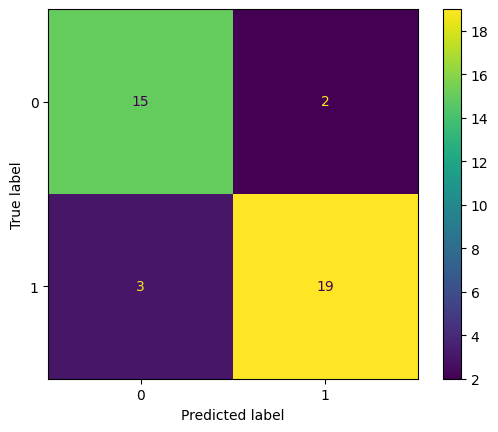

In [123]:
# Create the confusion matrix
cm = confusion_matrix(y_test, predictions)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

In [36]:
XGB_feature_importances = pd.Series(best_XGB.feature_importances_, index=X_train.columns).sort_values(ascending=False)

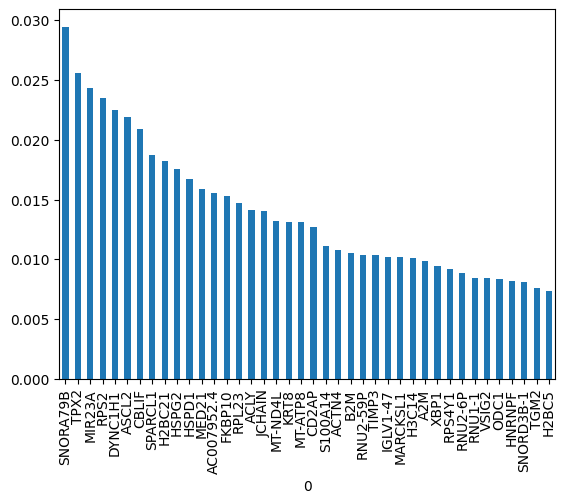

In [37]:
XGB_feature_importances[0:40].plot.bar();

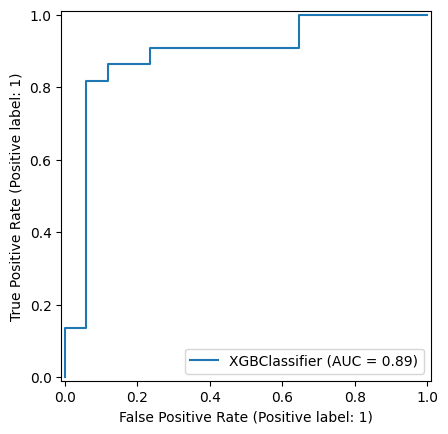

In [38]:
gb_disp = RocCurveDisplay.from_estimator(best_XGB, X_test, y_test)

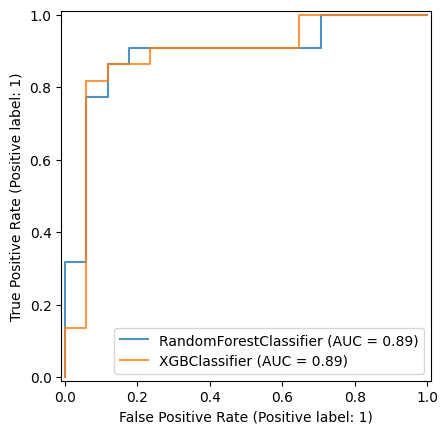

In [39]:
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(best_rf, X_test, y_test, ax=ax, alpha=0.8)
gb_disp.plot(ax=ax, alpha=0.8)
plt.show()

## Averaging feature importances

In [40]:
RF_feature_importances

0
TPX2      0.028991
ACLY      0.018684
TOP2A     0.014742
HSPD1     0.014364
DDX21     0.014334
            ...   
PGA3      0.000000
RNF128    0.000000
IGFBP5    0.000000
TSPAN3    0.000000
PHGR1     0.000000
Length: 1000, dtype: float64

In [41]:
averaged_importances = {}

for x in RF_feature_importances.index:
    if x in list(XGB_feature_importances.index):

        GB_importance = XGB_feature_importances[x]
        RF_importance = RF_feature_importances[x]
        mean_importance = (GB_importance + RF_importance) / 2
        
        averaged_importances[x] = mean_importance


In [42]:
ordered_importances = sorted(averaged_importances, key=averaged_importances.get, reverse=True)

In [43]:
ordered_importances

['TPX2',
 'ACLY',
 'HSPD1',
 'SNORA79B',
 'RPS2',
 'MIR23A',
 'ASCL2',
 'DYNC1H1',
 'H2BC21',
 'CBLIF',
 'SPARCL1',
 'HSPG2',
 'HNRNPF',
 'FKBP10',
 'H3C14',
 'SLC25A5',
 'CCT6A',
 'MED21',
 'AC007952.4',
 'RPL23',
 'CSE1L',
 'CD2AP',
 'MT-ATP8',
 'MT-ND4L',
 'TOP2A',
 'JCHAIN',
 'DDX21',
 'H2BC13',
 'KRT8',
 'CKS2',
 'CCT2',
 'S100A14',
 'B2M',
 'EPCAM',
 'TIMP3',
 'XBP1',
 'IGLV1-47',
 'ACTN4',
 'RNU2-59P',
 'H2BC5',
 'MARCKSL1',
 'H3C13',
 'A2M',
 'H2AC21',
 'ODC1',
 'EIF2S2',
 'SLC7A5',
 'H2AC18',
 'RPS4Y1',
 'SLC1A5',
 'KLHL11',
 'RNU2-6P',
 'VSIG2',
 'H2AW',
 'FTL',
 'SNRPB',
 'H1-2',
 'SNORD3B-1',
 'H2BC12',
 'SCARNA5',
 'RNU1-1',
 'SLPI',
 'H2BC11',
 'STOM',
 'MT-ND4',
 'IFITM3',
 'TGM2',
 'SCARNA21',
 'TUBB',
 'SNORD3B-2',
 'MT-ND5',
 'SNORA80D',
 'DSC2',
 'CEACAM5',
 'MRPL14',
 'CYCS',
 'PDIA4',
 'CPS1',
 'H2BU1',
 'MT-ND6',
 'H2AC11',
 'EIF3CL',
 'H2AC13',
 'MAPRE1',
 'AAR2',
 'VNN1',
 'CA2',
 'EIF2S3',
 'SFN',
 'IGKJ4',
 'ATP5F1B',
 'MT-TT',
 'MT-CYB',
 'H1-4',
 'APP',
 'C3

In [44]:
importance_df = pd.DataFrame(ordered_importances)

In [45]:
importance_df['mean_importance'] = importance_df[0].map(averaged_importances)

In [46]:
importance_df.rename(columns={0: "gene_name"}, inplace=True)

In [47]:
importance_df

,gene_name,mean_importance
0,TPX2,0.027289
1,ACLY,0.016407
2,HSPD1,0.015540
3,SNORA79B,0.015057
4,RPS2,0.012827
...,...,...
995,HLA-C,0.000000
996,PGA3,0.000000
997,RNF128,0.000000
998,IGFBP5,0.000000


In [48]:
importance_df.to_csv("Bulk_feature_importances.csv", sep=",", header = True)

# Single cell RNA data

In [49]:
import scanpy as sc
from scipy import sparse

In [50]:
adata = sc.read_h5ad("/Users/alex/Documents/BIOL0041-Project/OAC_masters_project/data/adata_with_rounded.h5ad")

## Get gene list of G0 signature

In [51]:
upregulated_genes = pd.read_csv('/Users/alex/Documents/BIOL0041-Project/OAC_masters_project/data/upregulated_genes.csv', header=None)
upregulated_genes = upregulated_genes[[1]]
upregulated_genes = list(upregulated_genes[1])

In [52]:
downregulated_genes = pd.read_csv('/Users/alex/Documents/BIOL0041-Project/OAC_masters_project/data/downregulated_genes.csv', header=None)
downregulated_genes = downregulated_genes[[1]]
downregulated_genes = list(downregulated_genes[1])

In [53]:
signature_genes = downregulated_genes + upregulated_genes

In [54]:
#sanity check, should = 139
len(signature_genes)

139

## Preparing dataset

In [55]:
# shifted log normalisation is independent cell to cell - can perform train/test splits without having to re-normalise afterwards
adata.X = adata.layers['log1p_norm']

In [56]:
#sanity check, ~8
adata.X.max()

np.float64(7.9698444347857444)

In [57]:
adata_obs_df = pd.DataFrame(adata.obs)

In [58]:
adata_obs_df['cell_type'] = np.where(~adata_obs_df['G0_class'].isna(), adata_obs_df['G0_class'],  adata_obs_df['cell_type'])

In [59]:
adata_obs_df.cell_type.value_counts()

cell_type
T               24998
B                6856
Fibroblast       4772
Myeloid          3055
NK               3013
Endothelial      2781
Plasmablast      2334
Mast             1631
Undetermined     1005
Epithelial        594
cycling           456
Cycling           436
G0 arrested       228
fast cycling      228
Name: count, dtype: int64

In [60]:
adata.obs = adata_obs_df

In [61]:
ML_adata = adata[adata.obs["cell_type"].isin(['G0 arrested', 'fast cycling'])]
non_Sig_genes = [name for name in ML_adata.var_names if not name in signature_genes]
ML_adata = ML_adata[:, non_Sig_genes]

In [62]:
ML_adata.obs.cell_type.value_counts()

cell_type
G0 arrested     228
fast cycling    228
Name: count, dtype: int64

In [63]:
ML_adata.X.shape

(456, 25678)

In [64]:
sc.pp.filter_genes(ML_adata, min_cells = 150)

/Users/alex/miniconda3/envs/ML_env/lib/python3.13/site-packages/scanpy/preprocessing/_simple.py:287: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


In [65]:
sc.pp.highly_variable_genes(ML_adata, layer = 'log1p_norm', n_top_genes = 1000)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [66]:
ML_adata.var.highly_variable.value_counts()

highly_variable
True     1000
False     142
Name: count, dtype: int64

In [67]:
ML_adata = ML_adata[:, ML_adata.var["highly_variable"]]

In [68]:
#should have 1000 most variable genes
ML_adata.X.shape

(456, 1000)

## transforming labels to numbers

In [69]:
def label_G0(x):
    if x == 'G0 arrested':
        return(1)
    else:
        return(0)

In [70]:
X = ML_adata.X

In [71]:
y = ML_adata.obs.cell_type.map(label_G0)

In [72]:
y.value_counts()

cell_type
1    228
0    228
Name: count, dtype: int64

## Train-test splitting data

In [ ]:
# split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

## Random forest - SC

In [ ]:
#create distribution of parameters
param_dist = {'bootstrap': [True, False],
              'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10],
              'n_estimators': [100, 150, 200, 250, 500, 750, 1000] 
              }

# Initialise classifier
rf = RandomForestClassifier(criterion='gini', random_state= 42)

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=1000, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

/Users/alex/miniconda3/envs/ML_env/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
2620 fits failed out of a total of 5000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2620 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/alex/miniconda3/envs/ML_env/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/alex/miniconda3/envs/ML_env/lib/python3.13/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/Users/alex/miniconda3/env

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=1000,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 150, 200, 250,
                                                         500, 750, 1000]})

In [ ]:
# Save the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True}


In [76]:
#manually set best_RF from above in case reset environment
#best_rf = RandomForestClassifier(criterion='gini', random_state= 42, n_estimators = 250, min_samples_split = 2, min_samples_leaf = 4, max_depth = 50, bootstrap = True,max_features='sqrt')
#best_rf.fit(X_train, y_train)

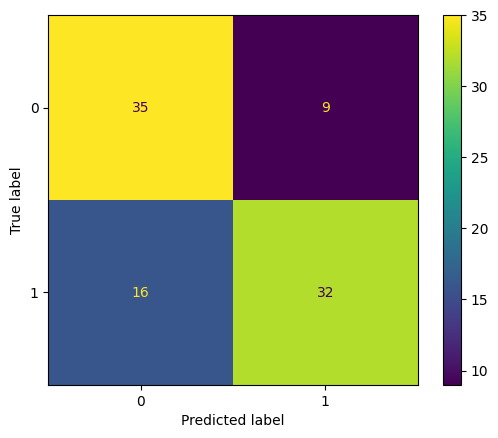

In [77]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [78]:
y_pred = best_rf.predict(X_test)

probs_rf = best_rf.predict_proba(X_test) [:,1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7282608695652174
Precision: 0.7804878048780488
Recall: 0.6666666666666666


In [79]:
RF_feature_importances = pd.DataFrame(best_rf.feature_importances_,
             index=ML_adata.var_names).sort_values(0, ascending=False)

In [80]:
RF_feature_importances

,0
CLU,0.010896
RPS21,0.009297
RPLP1,0.008882
RPS3,0.007700
FTL,0.007194
...,...
ID3,0.000000
BAG1,0.000000
BAZ1A,0.000000
NENF,0.000000


## XGBoost

In [81]:
from xgboost import XGBClassifier

In [82]:
params = {
              'n_estimators': [100, 150, 200, 250, 500, 750, 1000] ,
              'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
              'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
              'learning_rate':[0.001, 0.01, 0.1, 0.2, 0.3],
              'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
              'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
              'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
              'gamma': [0, 0.25, 0.5, 1.0],
              'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
              }

XGB = XGBClassifier(random_state = 42)

rand_search_XGB = RandomizedSearchCV(XGB, 
                                 param_distributions = params, 
                                 n_iter=1000, 
                                 cv=5,
                                 scoring = "accuracy")

rand_search_XGB.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'colsample_bytree': [0.4, 0.5, 0.6, 0.7,
                                                             0.8, 0.9, 1.0],
                                        'gamma': [0, 0.25, 0.5, 1.0],
                                        'learning_rate': [0.001, 0.01, 0.1, 0.2,
                                                          0.3],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'min_child_weight': [0.5, 1.0, 3.0, 5.0,
                                                             7.0, 10.0],
                                        'n_estimators': [100, 150, 200, 250,
                                                         500, 750, 1000],
                                        'reg_lambda': [0.1, 1.0, 5.0, 10.0,
                                                       50.0, 100.0],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1.0]},
                   scoring='accuracy')

In [ ]:
# Save the best model
best_XGB = rand_search_XGB.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search_XGB.best_params_)

Best hyperparameters: {'subsample': 0.5, 'reg_lambda': 100.0, 'n_estimators': 150, 'min_child_weight': 1.0, 'max_depth': 20, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.4}


In [84]:
#manual best XGB in case reset env

In [85]:
#best_XGB = XGBClassifier(subsample = 0.6, reg_lambda = 0.1, n_estimators = 100, min_child_weight = 1.0, max_depth = 30, learning_rate = 0.01, gamma = 0, colsample_bytree = 0.6, colsample_bylevel = 0.6, random_state = 42)

In [86]:
#best_XGB.fit(X_train, y_train)

Accuracy: 0.7282608695652174
Precision: 0.7674418604651163
Recall: 0.6875


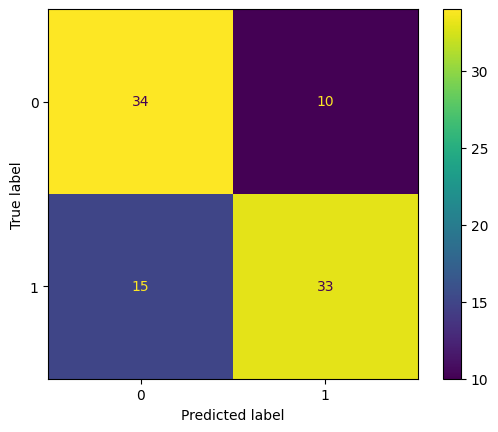

In [99]:
# Generate predictions with the best model
predictions = best_XGB.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, predictions)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

In [88]:
XGB_feature_importances = pd.DataFrame(best_XGB.feature_importances_,
             index=ML_adata.var_names).sort_values(0, ascending=False)

## SC - averaging feature importances

In [89]:
#convert the feature importance dfs to dictionaries so can use same averaging method as for the bulk ML data
RF_feature_importances = RF_feature_importances.reset_index().rename(columns={"index":"gene"})	
XGB_feature_importances = XGB_feature_importances.reset_index().rename(columns={"index":"gene"})	

RF_feature_importances = dict(zip(RF_feature_importances['gene'], RF_feature_importances[0]))
XGB_feature_importances = dict(zip(XGB_feature_importances['gene'], XGB_feature_importances[0]))

In [90]:
averaged_importances = {}

for x in RF_feature_importances.keys():
    if x in list(XGB_feature_importances.keys()):

        XGB_importance = XGB_feature_importances[x]
        RF_importance = RF_feature_importances[x]
        mean_importance = (XGB_importance + RF_importance) / 2
        
        averaged_importances[x] = mean_importance

In [91]:
averaged_importances

{'CLU': 0.00821237403633521,
 'RPS21': 0.009140666677300954,
 'RPLP1': 0.007514051631912704,
 'RPS3': 0.005400883585869418,
 'FTL': 0.006563690166460488,
 'ITM2B': 0.004999278261025754,
 'RPS14': 0.007348704754891938,
 'CTSD': 0.004732830932697021,
 'RPS12': 0.007828656605454717,
 'GLUL': 0.0038521156391910323,
 'RPL21': 0.008045799911845763,
 'RPL41': 0.004048477909430101,
 'CAPG': 0.0033869682426991227,
 'FTH1': 0.004262369964680685,
 'RPL37': 0.0035057352294644625,
 'RPS10': 0.0034850991870375215,
 'CLIC1': 0.0030903804440984978,
 'RPS27': 0.0024327948786228176,
 'NSMCE1': 0.003128342354675197,
 'CORO1A': 0.0031849021004865647,
 'RPL18': 0.0024791552909163798,
 'RPL10A': 0.0032198815491985312,
 'TSC22D1': 0.0027739555177423,
 'LAPTM4A': 0.0027937699294237235,
 'RPL18A': 0.005029774921982024,
 'RPS19': 0.006073928216823229,
 'FOXP1': 0.002943735128786642,
 'HINT1': 0.003478532447247841,
 'SH3BGRL3': 0.0028908472928725272,
 'RPS15A': 0.002417996039427284,
 'TRAC': 0.003094027553414094

In [92]:
ordered_importances = sorted(averaged_importances, key=averaged_importances.get, reverse=True)

In [93]:
ordered_importancesimportance_df = pd.DataFrame(ordered_importances)
importance_df = pd.DataFrame(ordered_importances)
importance_df['mean_importance'] = importance_df[0].map(averaged_importances)


In [94]:
importance_df = importance_df.rename(columns={0: 'gene_name'})

In [95]:
importance_df

,gene_name,mean_importance
0,RPS21,0.009141
1,CLU,0.008212
2,RPL21,0.008046
3,RPS12,0.007829
4,RPLP1,0.007514
...,...,...
995,PAFAH1B1,0.000000
996,HEBP2,0.000000
997,CLINT1,0.000000
998,BAZ1A,0.000000


In [96]:
importance_df.to_csv("SC_feature_importance.csv", sep=",", index=True, header=True)

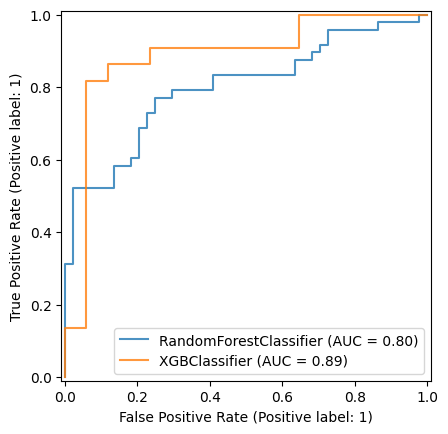

In [97]:
XGB_disp = RocCurveDisplay.from_estimator(best_XGB, X_test, y_test, ax=ax, alpha=0.8)
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(best_rf, X_test, y_test, ax=ax, alpha=0.8)
gb_disp.plot(ax=ax, alpha=0.8)
plt.show()